# Get Kicker data from aws mySQL DB

In [1]:
import mysql.connector
import pandas as pd
from pandas import DataFrame
from mysql.connector import errorcode
import matplotlib.pyplot as plt
% matplotlib inline

config = {
'user': 'db_gtown_2018',
'password': '****',
'port': '3306',
'host': 'nflnumbers.czuayagz62va.us-east-1.rds.amazonaws.com',
'database': 'db_nfl',
'raise_on_warnings': True,
}
 
try:
    cnx = mysql.connector.connect(**config)
    cursor = cnx.cursor()
    #Let's read all the rows in the table
    readContactPerson = """SELECT FGXP, PBP.GID, PBP.FKICKER, TIMO AS TIMO_REMAIN,
    CASE WHEN GOOD = 'Y' THEN 1 ELSE 0 END AS SUCCESS,
    CASE WHEN UPPER(DETAIL) LIKE '%BLOCKED%' THEN 1 ELSE 0 END AS BLOCKED,
    DPOS AS DRAFT_POSITION,
    DIST - (100 - CASE WHEN YFOG = '' THEN '98' ELSE YFOG END) AS YDS_BEHIND_LOS,
    PTSO - PTSD AS POINT_DIFFERENTIAL,
    CASE WHEN QTR IN ('2' , '4') AND MIN <= 2 AND (PTSO - PTSD) >= - 3 THEN 1 ELSE 0 END AS HIGH_PRESSURE,
    TEMP, HUMD, WSPD, WDIR, COND, SURF,
    PLAYER.POS1,PLAYER.POS2,PLAYER.height,PLAYER.weight,
    PLAYER.dob,
    PLAYER.forty,PLAYER.bench,PLAYER.vertical,PLAYER.broad,PLAYER.shuttle,PLAYER.cone,
    PLAYER.arm,PLAYER.hand,PLAYER.start,PLAYER.dcp
    FROM PBP
    LEFT OUTER JOIN PLAYER PLAYER ON PBP.FKICKER = PLAYER.PLAYER
    LEFT OUTER JOIN GAME ON PBP.GID = GAME.GID
    WHERE TYPE = 'FGXP'
    ORDER BY PBP.FKICKER , PBP.GID;"""
    cursor.execute(readContactPerson)
    #specify the attributes that you want to display
    df = DataFrame(cursor.fetchall())    
    
    cnx.commit()
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(err)
else:
    cursor.close()
    cnx.close()

In [2]:
df.columns = ['FGXP','GID','FKICKER','TIMO_REMAIN','SUCCESS','BLOCKED','DRAFT_POSITION','YDS_BEHIND_LOS','POINT_DIFFERENTIAL','HIGH_PRESSURE','TEMP','HUMD','WSPD','WDIR','COND','SURF',
             'POS1','POS2','height','weight','dob',
             'forty','bench','vertical','broad','shuttle','cone',
             'arm','hand','start','dcp']

In [3]:
df.head(3)

,FGXP,GID,FKICKER,TIMO_REMAIN,SUCCESS,BLOCKED,DRAFT_POSITION,YDS_BEHIND_LOS,POINT_DIFFERENTIAL,HIGH_PRESSURE,...,forty,bench,vertical,broad,shuttle,cone,arm,hand,start,dcp
0,FG,14,AD-0800,3,1,0,0,18.0,-7,0,...,0.0,0,0.0,0,0.0,0.0,0,0.0,1984,0
1,FG,14,AD-0800,0,1,0,0,18.0,-4,0,...,0.0,0,0.0,0,0.0,0.0,0,0.0,1984,0
2,XP,14,AD-0800,3,1,0,0,18.0,0,0,...,0.0,0,0.0,0,0.0,0.0,0,0.0,1984,0


## Number of XPs vs FGs 

In [4]:
df['FGXP'].value_counts()

XP    22009
FG    18165
Name: FGXP, dtype: int64

Number of XPs are slightly more than FGs 

## Success/Fail count by FG or XP

In [5]:
df.groupby(['FGXP','SUCCESS'])['FGXP'].count()

FGXP  SUCCESS
FG    0           3241
      1          14924
XP    0            438
      1          21571
Name: FGXP, dtype: int64

Success ratio of XP is more than FGs

## Weather conditions

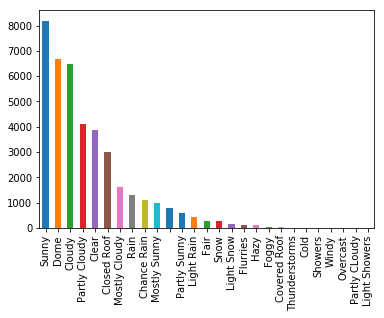

In [23]:
% matplotlib inline
df["COND"].value_counts().plot(kind='bar')

In [7]:
WeatherConditionsDifficultyLevel = {
    'unknown': '',
    'normal':['Closed Roof','Covered Roof','Dome','Clear','Cloudy',
              'Partly Cloudy','Mostly Cloudy','Fair','Partly CLoudy',
              'Sunny','Mostly Sunny','Partly Sunny'],
    'hard':['Chance Rain','Light Rain','Flurries','Light Snow','Light Showers'],
    'extreme':['Rain','Showers','Snow','Foggy','Hazy','Thunderstorms','Cold',
               'Windy','Overcast']
}

In [8]:
def multiple_replace(dict, text):
    for k,v in dict.items():        
        for val in dict[k]:
            if(val == text):
                return k
    return text
dfc = df.apply(lambda row: multiple_replace(WeatherConditionsDifficultyLevel, row['COND']), axis=1)

In [9]:
df["WeatherCondition"] = dfc
df.head(2)

,FGXP,GID,FKICKER,TIMO_REMAIN,SUCCESS,BLOCKED,DRAFT_POSITION,YDS_BEHIND_LOS,POINT_DIFFERENTIAL,HIGH_PRESSURE,...,bench,vertical,broad,shuttle,cone,arm,hand,start,dcp,WeatherCondition
0,FG,14,AD-0800,3,1,0,0,18.0,-7,0,...,0,0.0,0,0.0,0.0,0,0.0,1984,0,normal
1,FG,14,AD-0800,0,1,0,0,18.0,-4,0,...,0,0.0,0,0.0,0.0,0,0.0,1984,0,normal


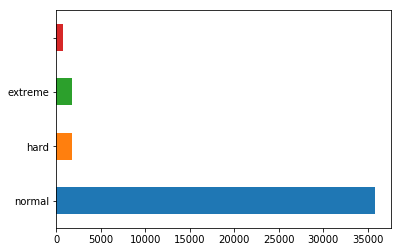

In [27]:
df["WeatherCondition"].value_counts().plot(kind='barh')

## SURF

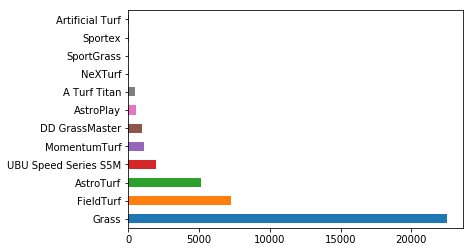

In [26]:
df["SURF"].value_counts().plot(kind='barh')

In [28]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TIMO_REMAIN,40174.0,2.381515,0.887430,0.0,2.0,3.0,3.0,3.00
SUCCESS,40174.0,0.908423,0.288431,0.0,1.0,1.0,1.0,1.00
BLOCKED,40174.0,0.013840,0.116827,0.0,0.0,0.0,0.0,1.00
DRAFT_POSITION,40174.0,57.468537,84.816554,0.0,0.0,0.0,118.0,329.00
YDS_BEHIND_LOS,40174.0,19.191666,3.766768,10.0,18.0,18.0,18.0,31.00
POINT_DIFFERENTIAL,40174.0,3.888211,10.569596,-49.0,-3.0,4.0,10.0,59.00
HIGH_PRESSURE,40174.0,0.153980,0.360934,0.0,0.0,0.0,0.0,1.00
height,40174.0,71.946284,1.939583,67.0,71.0,72.0,73.0,77.00
weight,40174.0,201.611764,16.213195,164.0,190.0,200.0,210.0,307.00
forty,40174.0,0.575039,1.582552,0.0,0.0,0.0,0.0,5.23


In [ ]:
df.plot(x='DIST', y='HIGH_PRESSURE', kind='scatter')